# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [4]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-05-04/data_eval_new/"
file_name = "int_norm_20160504_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [6]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [7]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [8]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

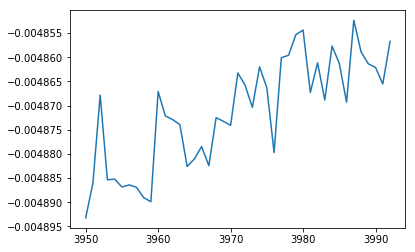

In [11]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

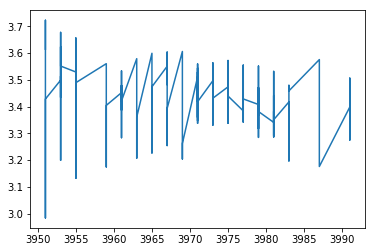

In [12]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [13]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 200ppb', 'NIST 350ppb'], dtype=object)

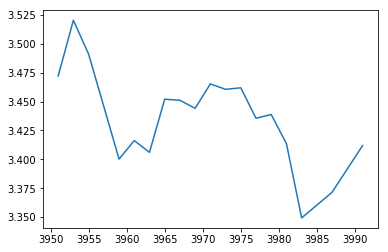

In [14]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

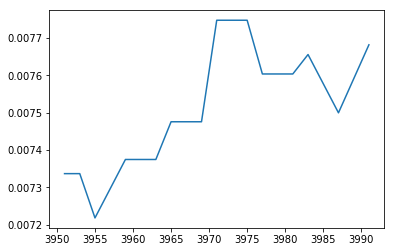

In [15]:
# Check background 
column = "120"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [16]:
background_mean = df_mean(background)

In [17]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [18]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [84]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [85]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [87]:
column = "124/118"
sample = "NIST 200ppb"

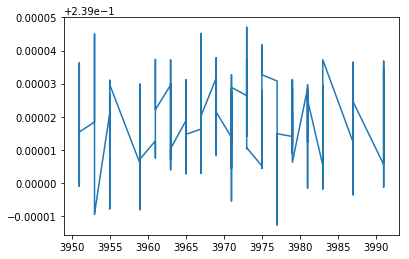

In [88]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [89]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [90]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-05-05 20:14:00,NIST 200ppb,2,1,3951,NaN,0.027184,0.013943,0.600265,NaN,0.354599,1.345930,NaN,0.239015
2016-05-05 20:14:00,NIST 200ppb,2,2,3951,0.040140,0.027180,0.013945,0.600319,0.316692,0.354585,1.345924,0.19125,0.239008
2016-05-05 20:14:00,NIST 200ppb,2,3,3951,0.040141,0.027175,0.013942,0.600274,0.316687,0.354579,1.345959,NaN,0.238999
2016-05-05 20:14:00,NIST 200ppb,2,4,3951,0.040139,0.027174,0.013943,0.600296,0.316691,0.354582,1.345965,NaN,0.239013
2016-05-05 20:14:00,NIST 200ppb,2,5,3951,0.040139,0.027176,0.013946,0.600317,0.316701,0.354599,1.345970,NaN,0.239030
2016-05-05 20:14:00,NIST 200ppb,2,6,3951,0.040136,0.027178,0.013944,0.600288,0.316692,0.354584,1.345978,0.19125,0.239021
2016-05-05 20:14:00,NIST 200ppb,2,7,3951,0.040139,0.027175,0.013945,0.600297,0.316693,0.354612,1.345989,NaN,0.239036
2016-05-05 20:14:00,NIST 200ppb,2,8,3951,0.040139,0.027177,0.013944,0.600300,0.316697,0.354591,1.345954,0.19125,0.239023
2016-05-05 20:14:00,NIST 200ppb,2,9,3951,0.040138,0.027178,0.013943,0.600293,0.316691,0.354583,1.345964,NaN,0.239023


In [91]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
3962        2016-05-05 22:42:00    0.239041
3968        2016-05-05 23:59:00    0.239038
3989        2016-05-06 04:20:00    0.239008
            2016-05-06 04:20:00    0.239004
Name: 124/118, dtype: float64

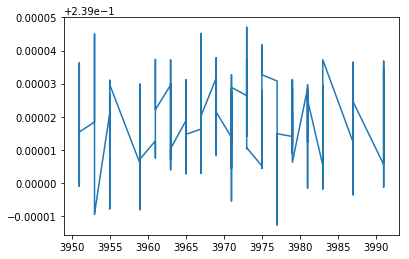

In [92]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [93]:
df[df["Sample"] == sample][column].std()

1.0183788444492981e-05

In [94]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [95]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

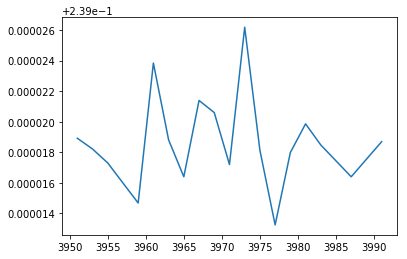

In [96]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [97]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2016-05-05 20:14:00,3951,NIST 200ppb,0.040139,0.027176,0.013945,0.600303,0.316695,0.354593,1.345957,0.19125,0.239019,0.000316,0.000043
2016-05-05 20:30:00,3952,NIST 350ppb,0.040146,0.027180,0.013945,0.600324,0.316700,0.354589,1.345950,0.19125,0.239021,0.000177,0.000040
2016-05-05 20:48:00,3953,NIST 200ppb,0.040137,0.027174,0.013944,0.600297,0.316690,0.354593,1.345959,0.19125,0.239018,0.000308,0.000035
2016-05-05 21:15:00,3955,NIST 200ppb,0.040144,0.027179,0.013945,0.600320,0.316700,0.354592,1.345961,0.19125,0.239017,0.000307,0.000040
2016-05-05 21:39:00,3957,NIST 350ppb,0.040143,0.027177,0.013945,0.600323,0.316702,0.354593,1.345943,0.19125,0.239018,0.000175,0.000038
2016-05-05 22:02:00,3959,NIST 200ppb,0.040143,0.027177,0.013945,0.600323,0.316705,0.354594,1.345962,0.19125,0.239015,0.000313,0.000042
2016-05-05 22:16:00,3960,NIST 350ppb,0.040145,0.027179,0.013946,0.600330,0.316704,0.354593,1.345945,0.19125,0.239019,0.000175,0.000037
2016-05-05 22:29:00,3961,NIST 200ppb,0.040142,0.027177,0.013946,0.600320,0.316705,0.354591,1.345982,0.19125,0.239024,0.000308,0.000041
2016-05-05 22:42:00,3962,NIST 350ppb,0.040145,0.027179,0.013946,0.600334,0.316707,0.354598,1.345956,0.19125,0.239023,0.000172,0.000039


In [98]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [99]:
drop_sum = []


In [100]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [101]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [102]:
data_mean_int_sum

112/118                   114/118                   115/118  \
                 mean       SD2 count      mean       SD2 count      mean   
Sample                                                                      
NIST 200ppb  0.040145  0.000007    18  0.027179  0.000005    18  0.013946   
NIST 350ppb  0.040147  0.000005    12  0.027180  0.000003    12  0.013947   

                              116/118  ...  122/118   124/118                  \
                  SD2 count      mean  ...    count      mean       SD2 count   
Sample                                 ...                                      
NIST 200ppb  0.000002    18  0.600325  ...       18  0.239019  0.000006    18   
NIST 350ppb  0.000002    12  0.600339  ...       12  0.239021  0.000007    12   

                Cd/Sn                     Te/Sn                  
                 mean       SD2 count      mean       SD2 count  
Sample                                                           
NIST 200ppb  0.000295  0.000032    18  0.000039  0.000008    18  
NIST 350ppb  0.000165  0.000016    12  0.000037  0.000005    12  

[2 rows x 33 columns]

In [103]:
date_list = []

epsilon_int_NIST_200= SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_NIST_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [104]:
epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [105]:
epsilon_int_NIST_200[epsilon_int_NIST_200["Filenumber"] > 1]

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-05-05 22:02:00,2.526529,0.009761,-0.38965,-0.10334,0.053233,0.0735,0.057858,-0.074048,2.220446e-12,-0.246337,NIST 200ppb


In [106]:

date_list = []

epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(date_list)
delta_raw_NIST_200 = delta_raw_NIST_200.drop(date_list)

In [107]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -3) & (df["Filenumber"] <= 3)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

def delta_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [108]:
epsilon_int_NIST_200 = epsilon_process(epsilon_int_NIST_200)
delta_raw_NIST_200 = delta_process(delta_raw_NIST_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [109]:
epsilon_int_NIST_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-05-05 20:30:00,3952,1.891086,1.868404,0.642218,0.403220,0.247355,-0.121758,-0.059791,-3.330669e-12,0.113264,NIST 350ppb
2016-05-05 20:48:00,3953,-1.090807,-1.376007,-0.899114,-0.239867,-0.229853,0.017162,-0.002804,6.661338e-12,0.004364,NIST 200ppb
2016-05-05 21:15:00,3955,0.985266,1.395278,0.378506,0.164896,0.083355,-0.031128,0.008512,-4.440892e-12,0.035707,NIST 200ppb
2016-05-05 21:39:00,3957,-0.238544,-0.336675,-0.324279,0.031489,-0.024012,-0.011288,-0.139101,-1.110223e-12,0.103537,NIST 350ppb
2016-05-05 22:02:00,3959,0.009761,-0.389650,-0.103340,0.053233,0.073500,0.057858,-0.074048,2.220446e-12,-0.246337,NIST 200ppb
2016-05-05 22:16:00,3960,0.625379,0.583660,0.146737,0.144550,-0.038368,0.023052,-0.204329,-1.110223e-12,0.004224,NIST 350ppb
2016-05-05 22:29:00,3961,-0.280885,0.090655,0.134540,-0.002487,0.013983,-0.094589,0.129958,-1.110223e-12,0.296655,NIST 200ppb
2016-05-05 22:42:00,3962,0.525080,0.849024,0.134184,0.252787,0.064532,0.152273,-0.142894,2.220446e-12,0.071554,NIST 350ppb
2016-05-05 22:55:00,3963,-0.201956,-1.130383,-0.060649,-0.190168,-0.072379,-0.014661,-0.053263,-3.330669e-12,-0.054659,NIST 200ppb


In [110]:
epsilon_NIST_200_sum = np.round(epsilon_int_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_200_sum = np.round(delta_raw_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [111]:
epsilon_sum_all

112/118              114/118              115/118               \
               mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
NIST 200ppb  -0.008  1.204    16   0.005  1.665    16  -0.026  1.018    16   
NIST 350ppb   0.494  1.187    12   0.323  1.576    12   0.116  1.015    12   

            116/118  ...  119/118 120/118              122/118             \
               mean  ...    count    mean    SD2 count    mean  SD2 count   
Sample               ...                                                    
NIST 200ppb  -0.007  ...       16  -0.002  0.112    16     0.0  0.0    16   
NIST 350ppb   0.221  ...       12  -0.119  0.158    12    -0.0  0.0    12   

            124/118               
               mean    SD2 count  
Sample                            
NIST 200ppb  -0.004  0.346    16  
NIST 350ppb   0.071  0.326    12  

[2 rows x 27 columns]

In [112]:
delta_raw_sum_all

112/118              114/118              115/118               \
               mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
NIST 200ppb   0.008  0.299    16   0.005  0.224    16   0.002  0.151    16   
NIST 350ppb   0.022  0.173    12   0.005  0.182    12  -0.007  0.130    12   

            116/118  ...  119/118 120/118              122/118               \
               mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample               ...                                                      
NIST 200ppb   0.003  ...       16  -0.003  0.094    16  -0.006  0.197    16   
NIST 350ppb   0.012  ...       12  -0.002  0.052    12   0.019  0.103    12   

            124/118               
               mean    SD2 count  
Sample                            
NIST 200ppb  -0.010  0.272    16  
NIST 350ppb   0.034  0.140    12  

[2 rows x 27 columns]

In [77]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [78]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [48]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [49]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [113]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [114]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [115]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [116]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined